In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Preparation

In [2]:
df = pd.read_csv("World_Unemployment_Data.csv")
df.head()

,Country Name,Country Code,Series Name,Series Code,1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,World,WLD,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,..,..,..,..,..,..,...,6.016229,6.048849,6.010331,5.916141,5.756398,5.58298,6.585288,6.033761,5.264616,4.961431
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Filter rows where 'Series Name' is 'Unemployment, total (% of total labor force)'
unemploy_df = df[df['Series Name'] == 'Unemployment, total (% of total labor force) (modeled ILO estimate)']

# Melt all columns that have 'YR' in their names
melted_df = unemploy_df.melt(id_vars=['Country Name'], 
                             value_vars=[col for col in unemploy_df.columns if '[YR' in col],
                             var_name='Year', 
                             value_name='Unemployment')

# Extract just the year (4-digit number) from the 'Year' column
melted_df['Year'] = melted_df['Year'].str.extract(r'(\d{4})')

# Pivot the DataFrame to make 'Country Name' as columns and 'Year' as index
df = melted_df.pivot(index='Year', columns='Country Name', values='Unemployment')

# Rename columns to include 'Unemployment' in each column name
df.columns = ['Unemployment ' + col for col in df.columns]
df

,Unemployment World
Year,
1974,..
1975,..
1976,..
1977,..
1978,..
1979,..
1980,..
1981,..
1982,..


In [4]:
df = df.iloc[17:]
df['Unemployment World'] = pd.to_numeric(df['Unemployment World'], errors='coerce')
df

C:\Users\GF63\AppData\Local\Temp\ipykernel_16596\4014813101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Unemployment World'] = pd.to_numeric(df['Unemployment World'], errors='coerce')


,Unemployment World
Year,
1991,4.996340
1992,5.149939
1993,5.417837
1994,5.667754
1995,5.820786
1996,5.908678
1997,5.954036
1998,6.125231
1999,6.265528


<AxesSubplot:xlabel='Year'>

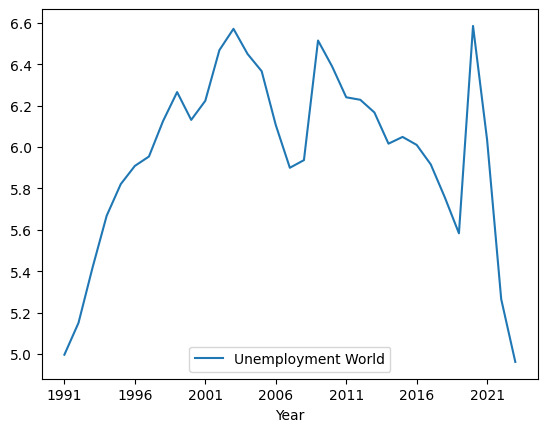

In [5]:
df.plot()

<AxesSubplot:xlabel='Year'>

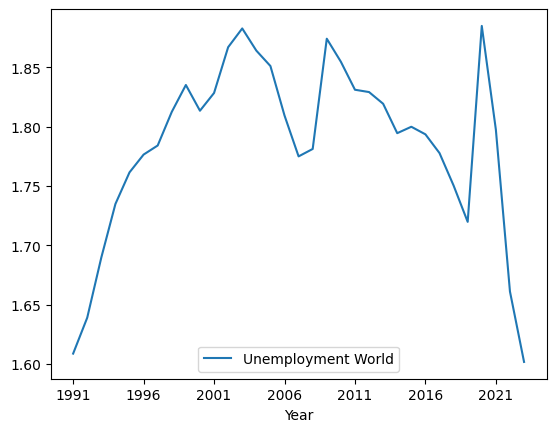

In [6]:
df = np.log(df)
df.plot()

In [7]:
df.reset_index(inplace=True)
msk = (df.index < len(df)-9)
df_train = df[msk].copy()
df_test = df[~msk].copy()

print(f'train length: {len(df_train)} & test length: {len(df_test)}')

train length: 24 & test length: 9


# Check ACF & PACF

In [8]:
df_train

,Year,Unemployment World
0,1991,1.608706
1,1992,1.638985
2,1993,1.689697
3,1994,1.734793
4,1995,1.761435
5,1996,1.776422
6,1997,1.784069
7,1998,1.812416
8,1999,1.835063
9,2000,1.813377


In [9]:
n_points = len(df_train)
max_lags = min(n_points // 2, 9)

C:\Users\GF63\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


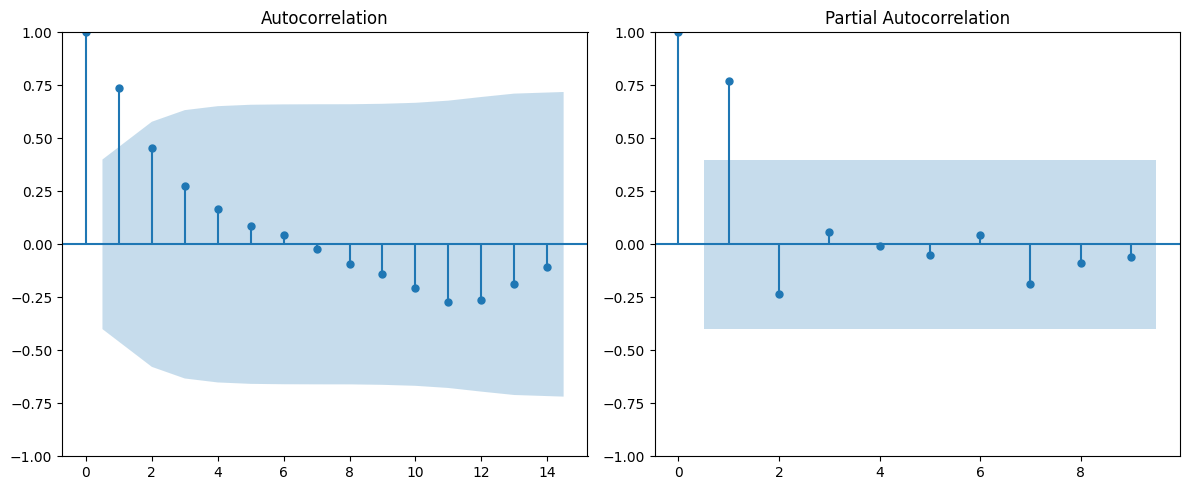

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(df_train['Unemployment World'], ax=ax[0])
plot_pacf(df_train['Unemployment World'], ax=ax[1], lags=max_lags)

plt.tight_layout()
plt.show()

In [11]:
adf_test = adfuller(df_train['Unemployment World'])
print(f'p-value: {adf_test[1]}')

p-value: 0.1820565198497932


# Make Stationary

In [12]:
df_train_diff = df_train['Unemployment World'].diff().dropna()
df_train_diff

1     0.030279
2     0.050712
3     0.045096
4     0.026642
5     0.014987
6     0.007647
7     0.028347
8     0.022646
9    -0.021686
10    0.014950
11    0.038587
12    0.015795
13   -0.018679
14   -0.012986
15   -0.041677
16   -0.034470
17    0.006255
18    0.092907
19   -0.019409
20   -0.023593
21   -0.001958
22   -0.009865
23   -0.024774
Name: Unemployment World, dtype: float64

<AxesSubplot:>

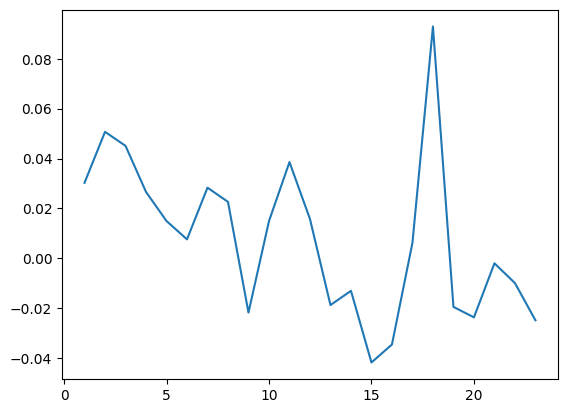

In [13]:
df_train_diff.plot()

In [15]:
n_points = len(df_train)
max_lags = min(n_points // 2, 9)

C:\Users\GF63\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


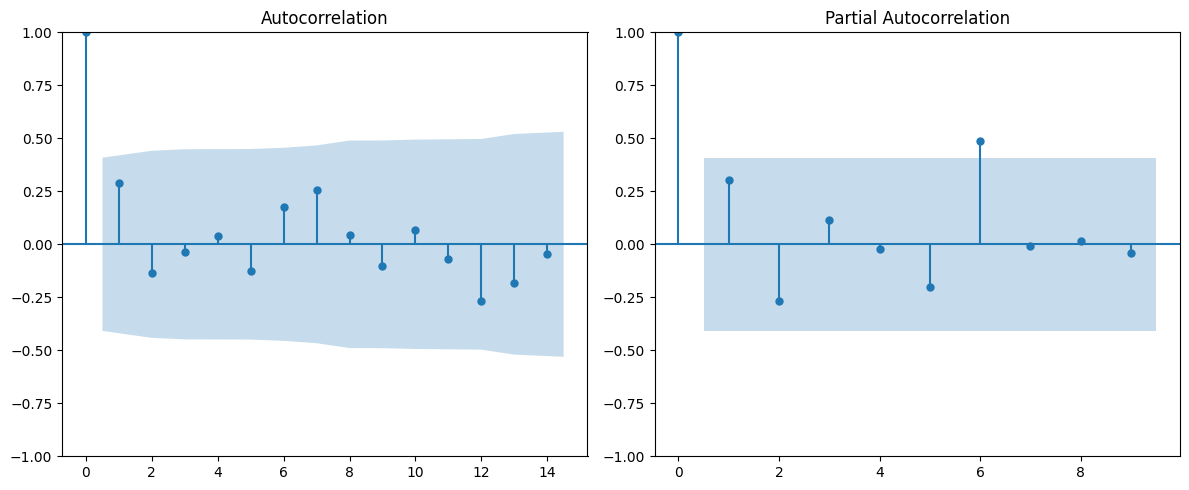

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(df_train_diff, ax=ax[0])
plot_pacf(df_train_diff, ax=ax[1], lags=max_lags)

plt.tight_layout()
plt.show()

In [18]:
adf_test_diff = adfuller(df_train_diff)
print(f'p-value: {adf_test_diff[1]}')

p-value: 0.012755261758482102


# Model Fit

## Fit to ARIMA Model

In [27]:
model = ARIMA(df_train['Unemployment World'], order=(5, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Unemployment World   No. Observations:                   24
Model:                 ARIMA(5, 0, 1)   Log Likelihood                  50.340
Date:                Thu, 26 Sep 2024   AIC                            -84.680
Time:                        03:13:11   BIC                            -75.256
Sample:                             0   HQIC                           -82.180
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7592      0.061     28.931      0.000       1.640       1.878
ar.L1          0.6411      4.190      0.153      0.878      -7.572       8.854
ar.L2          0.3755      5.772      0.065      0.9

C:\Users\GF63\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Visualize the Residu

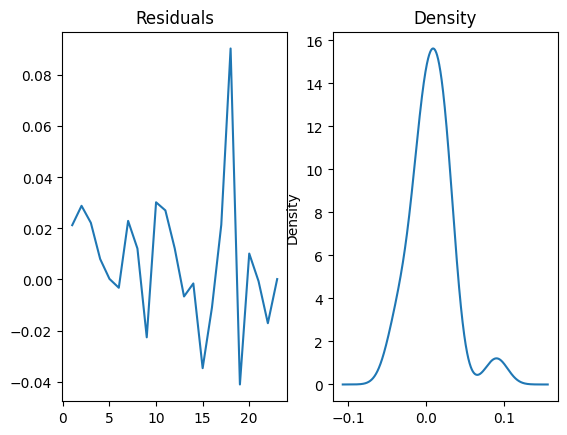

In [28]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

C:\Users\GF63\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


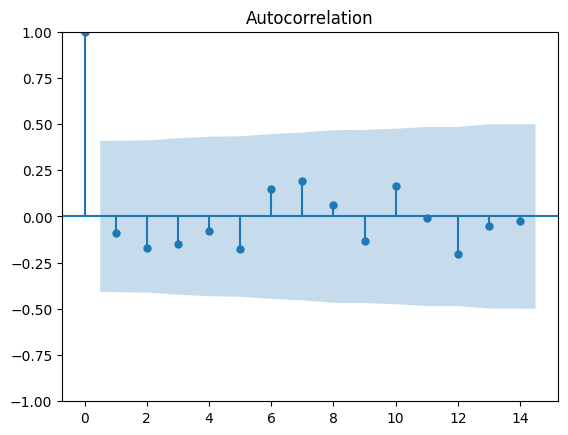

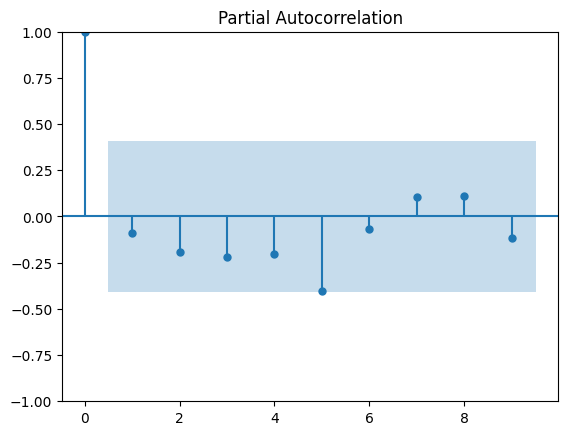

In [30]:
n_points = len(df_train)
max_lags = min(n_points // 2, 9)

acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals, lags=max_lags)

# Visualize Result

<AxesSubplot:>

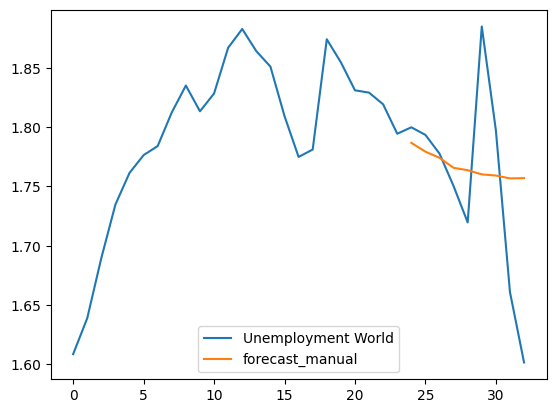

In [31]:
forecast_test = model_fit.forecast(len(df_test))
df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

# Forecast Result

In [32]:
forecast_years = 6
forecast_new = model_fit.forecast(steps=forecast_years).values

forecast_new

array([1.7867646 , 1.77934046, 1.77416125, 1.76571108, 1.76371518,
       1.76020785])

In [34]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

In [35]:
future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(1), periods=forecast_years, freq='Y')
forecast_df = pd.DataFrame(data = forecast_new, index=future_index, columns=['Unemployment World Forecast'])

forecast_df

,Unemployment World Forecast
2023-12-31,1.786765
2024-12-31,1.779340
2025-12-31,1.774161
2026-12-31,1.765711
2027-12-31,1.763715
2028-12-31,1.760208


In [45]:
df_with_forecast = pd.concat([df, forecast_df])

df_with_forecast

,Unemployment World,forecast_manual,Unemployment World Forecast
1991-01-01,1.608706,NaN,NaN
1992-01-01,1.638985,NaN,NaN
1993-01-01,1.689697,NaN,NaN
1994-01-01,1.734793,NaN,NaN
1995-01-01,1.761435,NaN,NaN
1996-01-01,1.776422,NaN,NaN
1997-01-01,1.784069,NaN,NaN
1998-01-01,1.812416,NaN,NaN
1999-01-01,1.835063,NaN,NaN
2000-01-01,1.813377,NaN,NaN


In [46]:
df_with_forecast = np.exp(df_with_forecast)

In [47]:
df_with_forecast.drop(pd.Timestamp('2023-12-31'), inplace=True)
df_with_forecast.index = df_with_forecast.index.year
df_with_forecast.head()

,Unemployment World,forecast_manual,Unemployment World Forecast
1991,4.996340,NaN,NaN
1992,5.149939,NaN,NaN
1993,5.417837,NaN,NaN
1994,5.667754,NaN,NaN
1995,5.820786,NaN,NaN


In [48]:
df_with_forecast = df_with_forecast.reset_index()
df_with_forecast.rename(columns={'index': 'year'}, inplace=True)
df_with_forecast

,year,Unemployment World,forecast_manual,Unemployment World Forecast
0,1991,4.996340,NaN,NaN
1,1992,5.149939,NaN,NaN
2,1993,5.417837,NaN,NaN
3,1994,5.667754,NaN,NaN
4,1995,5.820786,NaN,NaN
5,1996,5.908678,NaN,NaN
6,1997,5.954036,NaN,NaN
7,1998,6.125231,NaN,NaN
8,1999,6.265528,NaN,NaN
9,2000,6.131118,NaN,NaN


In [49]:
df_with_forecast[['year', 'Unemployment World', 'Unemployment World Forecast']].to_csv('Unemployment World Forecast.csv', index=False)